In [ ]:
import sys
import numpy as np
from main import dataloader, Coordinates
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from typing import List


In [ ]:
## Same function as in extract_features_final.ipynb

def features_extraction(dataloader, session_type):
    samples = list(dataloader)
    data = []

    for sample in tqdm(samples, desc="Extracting coords & labels"):
        session = sample[session_type]  
        if session is not None:
            player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])  
            player_coords = player_coords[:, [0, 2]]  # Keep only x and z

            if player_coords.shape[0] > 29999:
                player_coords = player_coords[:29999] 

            questionnaire_data = sample["questionnaire"]
            score_sum = None
            if questionnaire_data is not None:
                score_sum = sum(int(questionnaire_data[f"asrs{i}"]) for i in range(1, 19) if f"asrs{i}" in questionnaire_data)

            data.append({"id": sample.num_id, "label": score_sum, "trajectory": player_coords,})

    return pd.DataFrame(data)

def plot_trajectory(trajectory, line_color='red', line_width=2, figsize=(8, 6)):
    """
    Trace une seule trajectoire dans un notebook Jupyter avec une mise à l'échelle appropriée.

    Args:
        trajectory (np.array): Tableau de forme (nb_timestamps, 2) contenant les coordonnées de la trajectoire.
        line_color (str): Couleur de la ligne de la trajectoire (par défaut 'red').
        line_width (int): Épaisseur de la ligne de la trajectoire (par défaut 2).
        figsize (tuple): Taille de la figure (largeur, hauteur) (par défaut (8, 6)).
    """
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.plot(x, y, color=line_color, linewidth=line_width, markersize=5)

    ax.set_xlim([x.min() - 10, x.max() + 10])
    ax.set_ylim([y.min() - 10, y.max() + 10])

    ax.set_xlabel('Coordonnée X')
    ax.set_ylabel('Coordonnée Y')
    ax.set_title('Trajectoire')

    ax.grid(True)

    plt.show()
    
def plot_trajectories(df_1, df_2, line_color_1 = 'black', line_color_2 = 'red', line_width = 1, figsize=(8, 6)):
    """
    Trace deux groupes de trajectoires de couleur différentes.

    Args:
        df_1 (pd.DataFrame): DataFrame contenant les trajectoires du premier groupe.
        df_2 (pd.DataFrame): DataFrame contenant les trajectoires du second groupe.
        line_color_1 (str): Couleur de la ligne du premier groupe (par défaut 'black').
        line_color_2 (str): Couleur de la ligne du second groupe (par défaut 'red').
        line_width (int): Épaisseur de la ligne de la trajectoire (par défaut 1).
        figsize (tuple): Taille de la figure (largeur, hauteur) (par défaut (8, 6)).
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()

    for i, row in df_1.iterrows():
        trajectory = row['trajectory']
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        ax.plot(x, y, color=line_color_1, linewidth=line_width, alpha=0.5)

    for i, row in df_2.iterrows():
        trajectory = row['trajectory']
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        ax.plot(x, y, color=line_color_2, linewidth=line_width, alpha=0.5)

    x_min = min(df_1['trajectory'].apply(lambda x: x[:, 0].min()).min(), df_2['trajectory'].apply(lambda x: x[:, 0].min()).min())
    x_max = max(df_1['trajectory'].apply(lambda x: x[:, 0].max()).max(), df_2['trajectory'].apply(lambda x: x[:, 0].max()).max())
    y_min = min(df_1['trajectory'].apply(lambda x: x[:, 1].min()).min(), df_2['trajectory'].apply(lambda x: x[:, 1].min()).min())
    y_max = max(df_1['trajectory'].apply(lambda x: x[:, 1].max()).max(), df_2['trajectory'].apply(lambda x: x[:, 1].max()).max())
    ax.set_xlim([x_min - 10, x_max + 10])
    ax.set_ylim([y_min - 10, y_max + 10])
    
    ax.set_xlabel('Coordonnée X')
    ax.set_ylabel('Coordonnée Y')
    ax.set_title('Trajectoires')
    
    ax.grid(True)
    plt.show()
    
def reduce_number_of_points(extraction, n_points):
    """
    Réduit le nombre de points dans une extraction de trajectoires.
    
    Args:
        extraction (pd.DataFrame): Extraction de trajectoires.
        n_points (int): Nombre de points à conserver.
        
    Returns:
        pd.DataFrame: Extraction de trajectoires avec un nombre de points réduit.
    """
    data = []
    for _, row in tqdm(extraction.iterrows()):
        trajectory = row['trajectory']
        if len(trajectory) > n_points:
            indices = np.linspace(0, len(trajectory) - 1, n_points, dtype=int)
            reduced_trajectory = trajectory[indices]
        else:
            reduced_trajectory = trajectory
        data.append({"id": row['id'], "label": row['label'], "trajectory": reduced_trajectory})
    return pd.DataFrame(data)

## The two following functions help to transform the data storage format

def transform_trajectories_to_long_format(df, output_file, trajectory_column='trajectory', id_column='id'):
    """
    Transforme un DataFrame de trajectoires en un format long et enregistre le résultat en CSV.

    Args:
        output_file (str): Nom du fichier CSV de sortie (par défaut 'trajectories_long.csv').
        df (pd.DataFrame): DataFrame contenant les trajectoires.
        trajectory_column (str): Nom de la colonne contenant les trajectoires (numpy arrays).
        id_column (str): Nom de la colonne contenant les identifiants des individus.

    Returns:
        pd.DataFrame: DataFrame au format long avec les colonnes 'id', 'x', 'y'.
    """
    long_data = []

    for idx, row in df.iterrows():
        individual_id = row[id_column]
        
        trajectory = row[trajectory_column]
        
        if not isinstance(trajectory, np.ndarray) or trajectory.shape[1] != 2:
            raise ValueError(f"La trajectoire de l'individu {individual_id} n'est pas un numpy array de forme (nb_timestamps, 2).")
        
        for point in trajectory:
            x, y = point
            long_data.append({
                'id': individual_id,
                'x': x,
                'y': y
            })

    long_df = pd.DataFrame(long_data)
    
    long_df.to_csv(output_file, index=False)
    print(f"Le DataFrame a été enregistré dans le fichier {output_file}")
    
    return long_df

def transform_long_to_trajectories(df, id_column='idx', x_column='location.lat', y_column='location.long', trajectory_column='trajectory'):
    """
    Transforme un DataFrame au format long en un DataFrame de trajectoires compact.

    Args:
        df (pd.DataFrame): DataFrame au format long avec les colonnes 'id', 'x', 'y'.
        id_column (str): Nom de la colonne contenant les identifiants des individus.
        x_column (str): Nom de la colonne contenant les coordonnées x.
        y_column (str): Nom de la colonne contenant les coordonnées y.
        trajectory_column (str): Nom de la colonne à créer pour stocker les trajectoires.

    Returns:
        pd.DataFrame: DataFrame au format compact avec les colonnes 'id' et 'trajectory'.
    """
    trajectories_dict = {}

    for idx, row in df.iterrows():
        individual_id = row[id_column]
        x = row[x_column]
        y = row[y_column]
        
        if individual_id not in trajectories_dict:
            trajectories_dict[individual_id] = []
        
        trajectories_dict[individual_id].append([x, y])

    compact_data = []
    for individual_id, trajectory in trajectories_dict.items():
        compact_data.append({
            id_column: individual_id,
            trajectory_column: np.array(trajectory)  # Convertir en np array
        })

    compact_df = pd.DataFrame(compact_data)
    
    return compact_df


In [ ]:
df_extraction_uniform = features_extraction(dataloader, "uniform")  
df_extraction_patchy = features_extraction(dataloader, "patchy")
df_reduced_uniform = reduce_number_of_points(df_extraction_uniform, 400)
df_reduced_patchy = reduce_number_of_points(df_extraction_patchy, 400)

Extracting coords & labels: 100%|██████████| 39/39 [00:26<00:00,  1.50it/s]
39it [00:00, 1094.55it/s]
38it [00:00, 2116.84it/s]


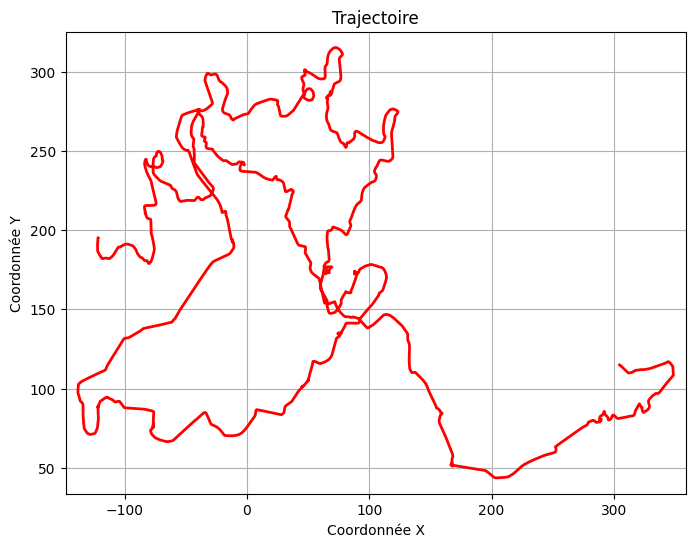

In [37]:
plot_trajectory(df_extraction_uniform.iloc[0]["trajectory"])

In [ ]:
transform_trajectories_to_long_format(df_reduced_uniform, 'uniform_400.csv')  
transform_trajectories_to_long_format(df_reduced_patchy, 'patchy_400.csv')

Le DataFrame a été enregistré dans le fichier uniform_400.csv
Le DataFrame a été enregistré dans le fichier patchy_400.csv


,id,x,y
0,31,-121.653000,195.311996
1,31,-121.658539,195.315689
2,31,-121.658539,195.315689
3,31,-121.658539,195.315689
4,31,-121.235138,195.288528
...,...,...,...
15195,12,334.635864,-44.231415
15196,12,338.197937,-42.374634
15197,12,342.116852,-38.870068
15198,12,341.490814,-33.156765


In [39]:
GENERATED_TRAJECTORIES_PATH = Path.cwd().parent.parent/"generated_trajectories"
df_generated_patchy_10 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=10_0_k0_patchy_400.csv')
df_generated_patchy_90 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=90_0_k0_patchy_400.csv')
df_generated_patchy_200 = pd.read_csv(GENERATED_TRAJECTORIES_PATH/'VAE_WILDGEN_EPOCHS=200_0_k0_patchy_400.csv')
df_generated_patchy_10 = transform_long_to_trajectories(df_generated_patchy_10)
df_generated_patchy_90 = transform_long_to_trajectories(df_generated_patchy_90)
df_generated_patchy_200 = transform_long_to_trajectories(df_generated_patchy_200)

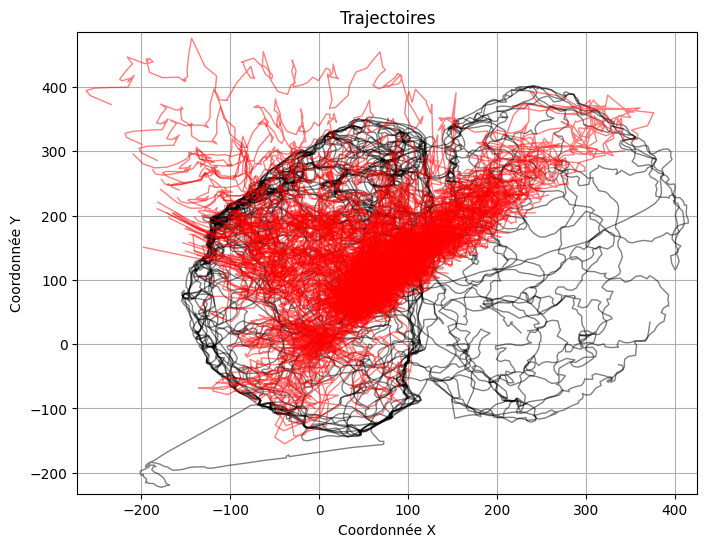

In [ ]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_10)  
#10 epochs of training

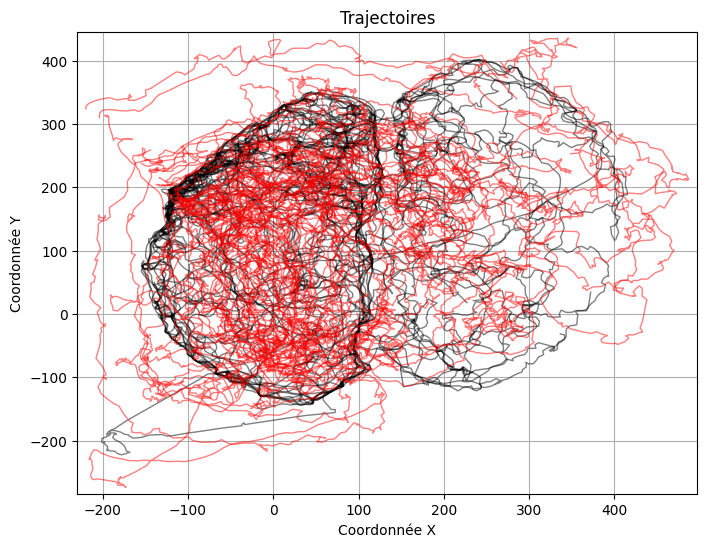

In [ ]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_90)

# 50 epochs of training

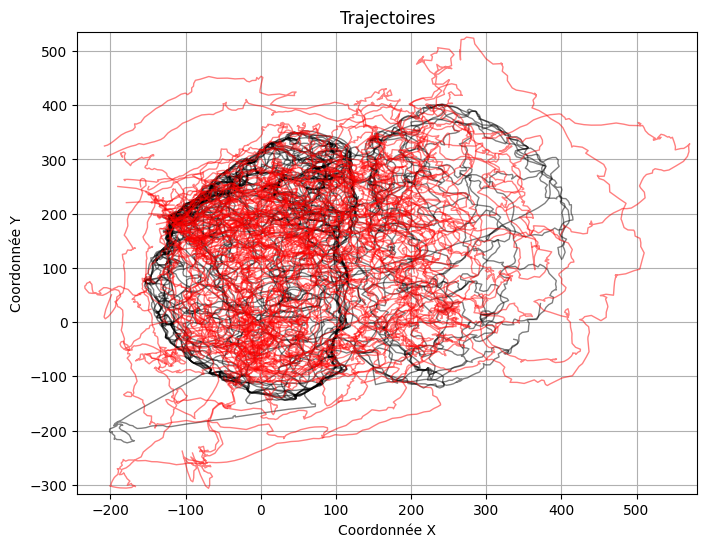

In [ ]:
plot_trajectories(df_reduced_patchy, df_generated_patchy_200)
#200 epochs of training

# Test of features on synthetic trajectories

We only compute global features, no series features, as the shape is different and it would be too sensitive and unstable

## Define the functions to compute features
(This cell is a copy from extract_features_final.ipiynb)

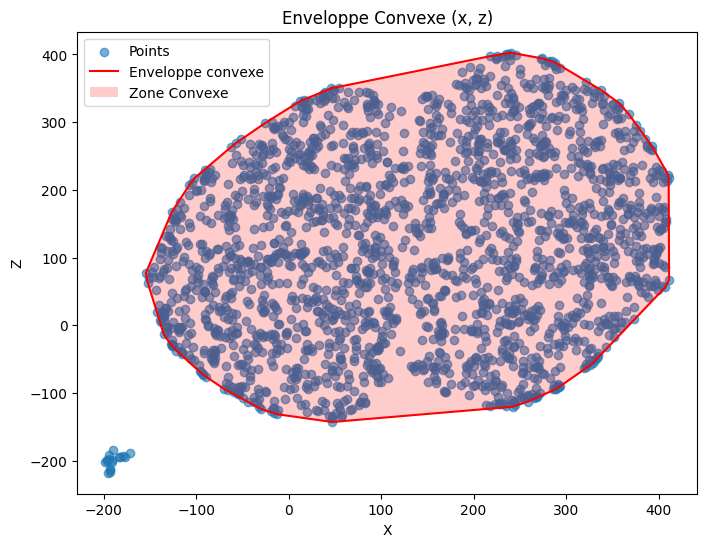

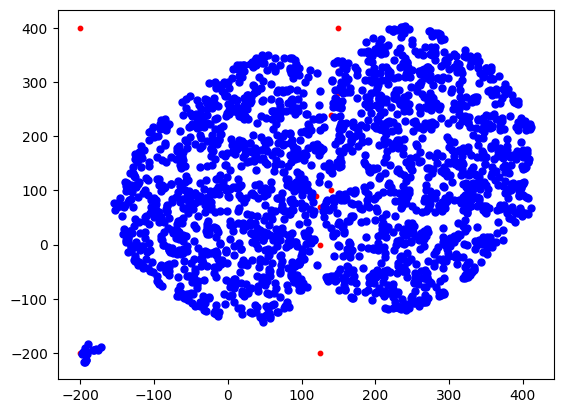

In [ ]:
DISPLAY = True

from scipy.spatial import ConvexHull

def compute_convex_hull_xz(coords: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    
    mask = (points[:, 0] > -170) & (points[:, 1] > -170)
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points

def plot_convex_hull_xz(coords: List[Coordinates]):
    """
    Trace les positions et l'enveloppe convexe pour une liste de coordonnées en utilisant x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
    """
    hull, hull_points = compute_convex_hull_xz(coords)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z pour le tracé
    
    hull_points_array = np.array([p.to_vect()[[0, 2]] for p in hull_points])  # Convertir pour le tracé

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], label="Points", alpha=0.6)
    plt.plot(np.append(hull_points_array[:, 0], hull_points_array[0, 0]),
             np.append(hull_points_array[:, 1], hull_points_array[0, 1]),
             'r-', label="Enveloppe convexe")
    plt.fill(hull_points_array[:, 0], hull_points_array[:, 1],
             'r', alpha=0.2, label="Zone Convexe")
    plt.legend()
    plt.title("Enveloppe Convexe (x, z)")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.show()
    
from scipy.spatial import distance

def average_distance_to_hull(df: pd.DataFrame, coords: List, metric: str) -> pd.DataFrame:
    """
    Calcule la distance moyenne des points d'une trajectoire aux bords de l'enveloppe convexe.

    Args:
        df (pd.DataFrame): DataFrame contenant les trajectoires et les ID des joueurs.
        coords (List): Liste des positions des champignons.
        metric (str): La métrique à utiliser pour calculer les distances.

    Returns:
        pd.DataFrame: DataFrame contenant les ID des joueurs et leur distance moyenne à l'enveloppe convexe.
    """
    # Calculer l'enveloppe convexe
    hull, _ = compute_convex_hull_xz(coords)
    hull_points = hull.points[hull.vertices]  # Points de l'enveloppe convexe

    # Calculer les distances moyennes pour chaque joueur
    distances = []
    for _, row in df.iterrows():
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire

        # Calculer les distances minimales au bord de la hull
        dist_matrix = distance.cdist(trajectory, hull_points, metric=metric)
        min_distances = np.min(dist_matrix, axis=1)  # Distance minimale pour chaque point
        avg_distance = np.mean(min_distances)  # Moyenne des distances
        
        distances.append({"id": player_id, "avg_distance_to_hull": avg_distance})

    return pd.DataFrame(distances)

def compute_diameter(df_time: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le diamètre d'une trajectoire (avec df_time), puis l'ajoute à df.
    
    Args:
        df_time (pd.DataFrame): DataFrame contenant une colonne "trajectory" et "id", d'où sera calculé le diamètre.
        
    Returns:
        pd.DataFrame: DataFrame df auquel sera ajoutée la colonne "diameter".
    """

    diameters = []
    for _,row in tqdm(df_time.iterrows(), desc = "Computing diameters", total = len(df_time['id'])):
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire
        diameter = np.max(distance.pdist(trajectory, metric="euclidean"))

        diameters.append({"id": player_id, "diameter": diameter})

    df_temp = pd.DataFrame(diameters)
    return df_temp
def compute_convex_hull_xz_with_polyline_limit(coords: List[Coordinates], polyline: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z,
    tout en excluant les points à droite de la pseudo-ligne définie par les points de la polyline.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
        polyline (List[Coordinates]): Liste des points qui définissent la pseudo-ligne de séparation.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    # Convertir les points de la polyline en numpy
    polyline_points = np.array([p.to_vect()[[0, 2]] for p in polyline])
    
    # Initialisation du masque pour filtrer les points
    mask = np.ones(len(points), dtype=bool)
    
    # Pour chaque segment de la polyline, déterminer de quel côté chaque point se trouve
    for i in range(len(polyline_points) - 1):
        p1 = polyline_points[i]
        p2 = polyline_points[i + 1]
        
        # Calculer le vecteur directeur du segment
        direction = p2 - p1
        
        # Calculer le vecteur normal au segment
        normal = np.array([direction[1], -direction[0]])  # Normal à la ligne (x, z)
        
        # Appliquer le produit scalaire pour déterminer si les points sont à gauche ou à droite du segment
        mask &= np.dot(points - p1, normal) >= 0  # Seulement à gauche ou sur la ligne
    
    # Filtrer les points
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points

point1 = Coordinates(x=150, y=0, z=400)
point2 = Coordinates(x=150, y=0, z=320)
point3 = Coordinates(x=150, y=0, z=280)
point4 = Coordinates(x=140,y=0, z=240)
point5 = Coordinates(x=140,y=0, z=100)
point6 = Coordinates(x=120,y=0, z=90)
point7 = Coordinates(x=125,y=0, z=70)
point8 = Coordinates(x=125,y=0, z=0)
point9 = Coordinates(x=125,y=0, z=-200)
point10 = Coordinates(x=-200,y=0, z=-200)
point11 = Coordinates(x=-200,y=0, z=400)
river_points = [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11]

# 2 last point are made to define a closed polygon

sample = next(iter(dataloader))
session_uniform = sample.load_session("uniform")
session_patchy = sample.load_session("patchy")
coords_uniform = session_uniform.mushroom_coords
coords_patchy = session_patchy.mushroom_coords
coords = coords_uniform + coords_patchy
hull, hull_points = compute_convex_hull_xz(coords)
plot_convex_hull_xz(coords)

if DISPLAY:
    for p in river_points:
        plt.scatter(p.to_vect()[0], p.to_vect()[2], color='red', s=10)

    for mushroom in coords:
        plt.plot(mushroom.to_vect()[0], mushroom.to_vect()[2], color = 'blue', marker = 'o', markersize = 5) 

    plt.show()

from shapely.geometry import Point, Polygon

def count_points_in_and_out(trajectory, river_points):
    """
    Compte le nombre de points d'une trajectoire à l'intérieur et à l'extérieur de la polyligne.
    
    Arguments:
    - trajectory: Liste de points représentant la trajectoire.
    - river_points: Liste des points qui définissent la polyligne de séparation (la rivière).
    
    Retour:
    - Compte des points à l'intérieur et à l'extérieur de la polyligne.
    """
    # Créer le polygone de la rivière à partir de la polyligne
    river_coords = [(p.to_vect()[0], p.to_vect()[2]) for p in river_points]
    polygon = Polygon(river_coords)

    inside_count = 0
    outside_count = 0

    # Vérifier pour chaque point de la trajectoire
    for p in trajectory:
        point = Point(p[0], p[1])  # Créer un objet Point
        if polygon.contains(point):
            inside_count += 1
        else:
            outside_count += 1

    return inside_count, outside_count

def plot_trajectory_with_river(trajectory, river_points, inside_count, outside_count):
    """
    Trace la trajectoire et la polyligne de la rivière avec le nombre de points à l'intérieur et à l'extérieur de la ligne.
    """
    # Tracer la polyligne de la rivière
    river_x = [p.to_vect()[0] for p in river_points[:-2]]
    river_z = [p.to_vect()[2] for p in river_points[:-2]]
    plt.plot(river_x, river_z, color='red', label="Rivière", lw=2)

    # Tracer la trajectoire
    trajectory_x = [p[0] for p in trajectory]
    trajectory_z = [p[1] for p in trajectory]
    plt.plot(trajectory_x, trajectory_z, color='blue', label="Trajectoire")

    # Affichage des résultats
    plt.title(f"Trajectoire - Points à gauche: {inside_count}, Points à droite: {outside_count}")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.legend()
    plt.show()
    
def compute_time_ratio(df_time: pd.DataFrame, river_points = river_points) -> pd.DataFrame:
    """
    Calcule le ratio de temps passé à droite par rapport au temps passé à gauche de la rivière.
    
    Arguments:
    - df_time (pd.DataFrame): DataFrame contenant les trajectoires et les IDs des joueurs.
    - river_points: Liste des points définissant la rivière (polyligne de séparation).
    
    Retour:
    - pd.DataFrame: DataFrame contenant l'ID et le ratio de temps passé à droite/gauche.
    """

    ratios = []
    for _,row in tqdm(df_time.iterrows(), desc = "Computing ratios", total = len(df_time['id'])):
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire
        inside_count, outside_count = count_points_in_and_out(trajectory, river_points)
        ratio = outside_count / (inside_count+outside_count)
        ratios.append({"id": player_id, "time_ratio_spent_on_right_side": ratio})

    df_temp = pd.DataFrame(ratios)
    return df_temp


## Actual pipeline of computation

### Uniform

In [ ]:
## LOADING THE SYNTHETIC DATA FROM NPY (trained on uniform trajectories)
generated_trajectories_on_uniform = np.load(GENERATED_TRAJECTORIES_PATH/'vae_experiments/generated_trajectories_uniform.npy')
generated_trajectories_on_uniform = np.array(generated_trajectories_on_uniform)
df_generated_trajectories_uniform = pd.DataFrame({
    'id': range(len(generated_trajectories_on_uniform)), # Thats a synthetic id
    'trajectory': list(generated_trajectories_on_uniform)
})

df_generated_trajectories_uniform.head()

## COMPUTING THE FEATURES
df_distance_to_hull_uniform = average_distance_to_hull(df_generated_trajectories_uniform, coords, "euclidean")
df_diameter_uniform = compute_diameter(df_generated_trajectories_uniform)
df_ratio_uniform = compute_time_ratio(df_generated_trajectories_uniform)
df_features_uniform = pd.merge(df_distance_to_hull_uniform, df_diameter_uniform, on="id")
df_features_uniform = pd.merge(df_features_uniform, df_ratio_uniform, on="id")
df_features_uniform.to_csv("results/synthetic_features_uniform.csv", index=False)
df_features_uniform.head()



Computing ratios: 100%|██████████| 39/39 [00:01<00:00, 38.25it/s]


,id,avg_distance_to_hull,diameter,time_ratio_spent_on_right_side
0,0,175.733017,404.492542,0.6500
1,1,173.664532,401.837659,0.5575
2,2,164.899328,432.374696,0.6750
3,3,129.281665,469.615944,0.7100
4,4,109.163207,596.781541,0.6850


### Patchy

In [ ]:
## LOADING THE SYNTHETIC DATA FROM NPY (trained on patchy trajectories)
generated_trajectories_on_patchy = np.load(GENERATED_TRAJECTORIES_PATH/'vae_experiments/generated_trajectories_patchy.npy')
generated_trajectories_on_patchy = np.array(generated_trajectories_on_patchy)
df_generated_trajectories_patchy = pd.DataFrame({
    'id': range(len(generated_trajectories_on_patchy)), # Thats a synthetic id
    'trajectory': list(generated_trajectories_on_patchy)
})

df_generated_trajectories_patchy.head()

## COMPUTING THE FEATURES
df_distance_to_hull_patchy = average_distance_to_hull(df_generated_trajectories_patchy, coords, "euclidean")
df_diameter_patchy = compute_diameter(df_generated_trajectories_patchy)
df_ratio_patchy = compute_time_ratio(df_generated_trajectories_patchy)
df_features_patchy = pd.merge(df_distance_to_hull_patchy, df_diameter_patchy, on="id")
df_features_patchy = pd.merge(df_features_patchy, df_ratio_patchy, on="id")
df_features_patchy.to_csv("results/synthetic_features_patchy.csv", index=False)
df_features_patchy.head()




Computing ratios: 100%|██████████| 39/39 [00:01<00:00, 35.93it/s]


,id,avg_distance_to_hull,diameter,time_ratio_spent_on_right_side
0,0,68.126500,366.773636,0.0000
1,1,79.554246,673.475177,0.2775
2,2,54.487428,522.275109,0.0325
3,3,91.841151,524.916541,0.2375
4,4,135.246021,434.712408,0.3575


### Merged


In [47]:
generated_trajectories_on_merged = np.load(GENERATED_TRAJECTORIES_PATH/'vae_experiments/generated_trajectories_merged.npy')
generated_trajectories_on_merged = np.array(generated_trajectories_on_merged)
df_generated_trajectories_merged = pd.DataFrame({
    'id': range(len(generated_trajectories_on_merged)), # Thats a synthetic id
    'trajectory': list(generated_trajectories_on_merged)
})

df_distance_to_hull_merged = average_distance_to_hull(df_generated_trajectories_merged, coords, "euclidean")
df_diameter_merged = compute_diameter(df_generated_trajectories_merged)
df_ratio_merged = compute_time_ratio(df_generated_trajectories_merged)
df_features_merged = pd.merge(df_distance_to_hull_merged, df_diameter_merged, on="id")
df_features_merged = pd.merge(df_features_merged, df_ratio_merged, on="id")
df_features_merged.to_csv("results/synthetic_features_merged.csv", index=False)
df_features_merged.head()

Computing ratios: 100%|██████████| 39/39 [00:01<00:00, 32.58it/s]


,id,avg_distance_to_hull,diameter,time_ratio_spent_on_right_side
0,0,103.395106,170.954099,0.0000
1,1,125.868972,134.081191,0.0000
2,2,111.566021,444.017852,0.6575
3,3,125.012172,455.562080,0.4925
4,4,71.543625,208.540822,0.0000


## Comparison of the synthetic features with the real data features
(we only compare distributions here)

In [ ]:
synthetic_features_uniform = pd.read_csv("results/synthetic_features_uniform.csv")
synthetic_features_patchy = pd.read_csv("results/synthetic_features_patchy.csv")
original_features_uniform = pd.read_csv("results/uniform_features.csv", sep = ";")
original_features_patchy = pd.read_csv("results/patchy_features.csv", sep = ";")


original_features_uniform = original_features_uniform[['id', 'avg_distance_to_hull','diameter','time_ratio_spent_on_right_side']]
original_features_patchy = original_features_patchy[['id', 'avg_distance_to_hull', 'diameter', 'time_ratio_spent_on_right_side']]



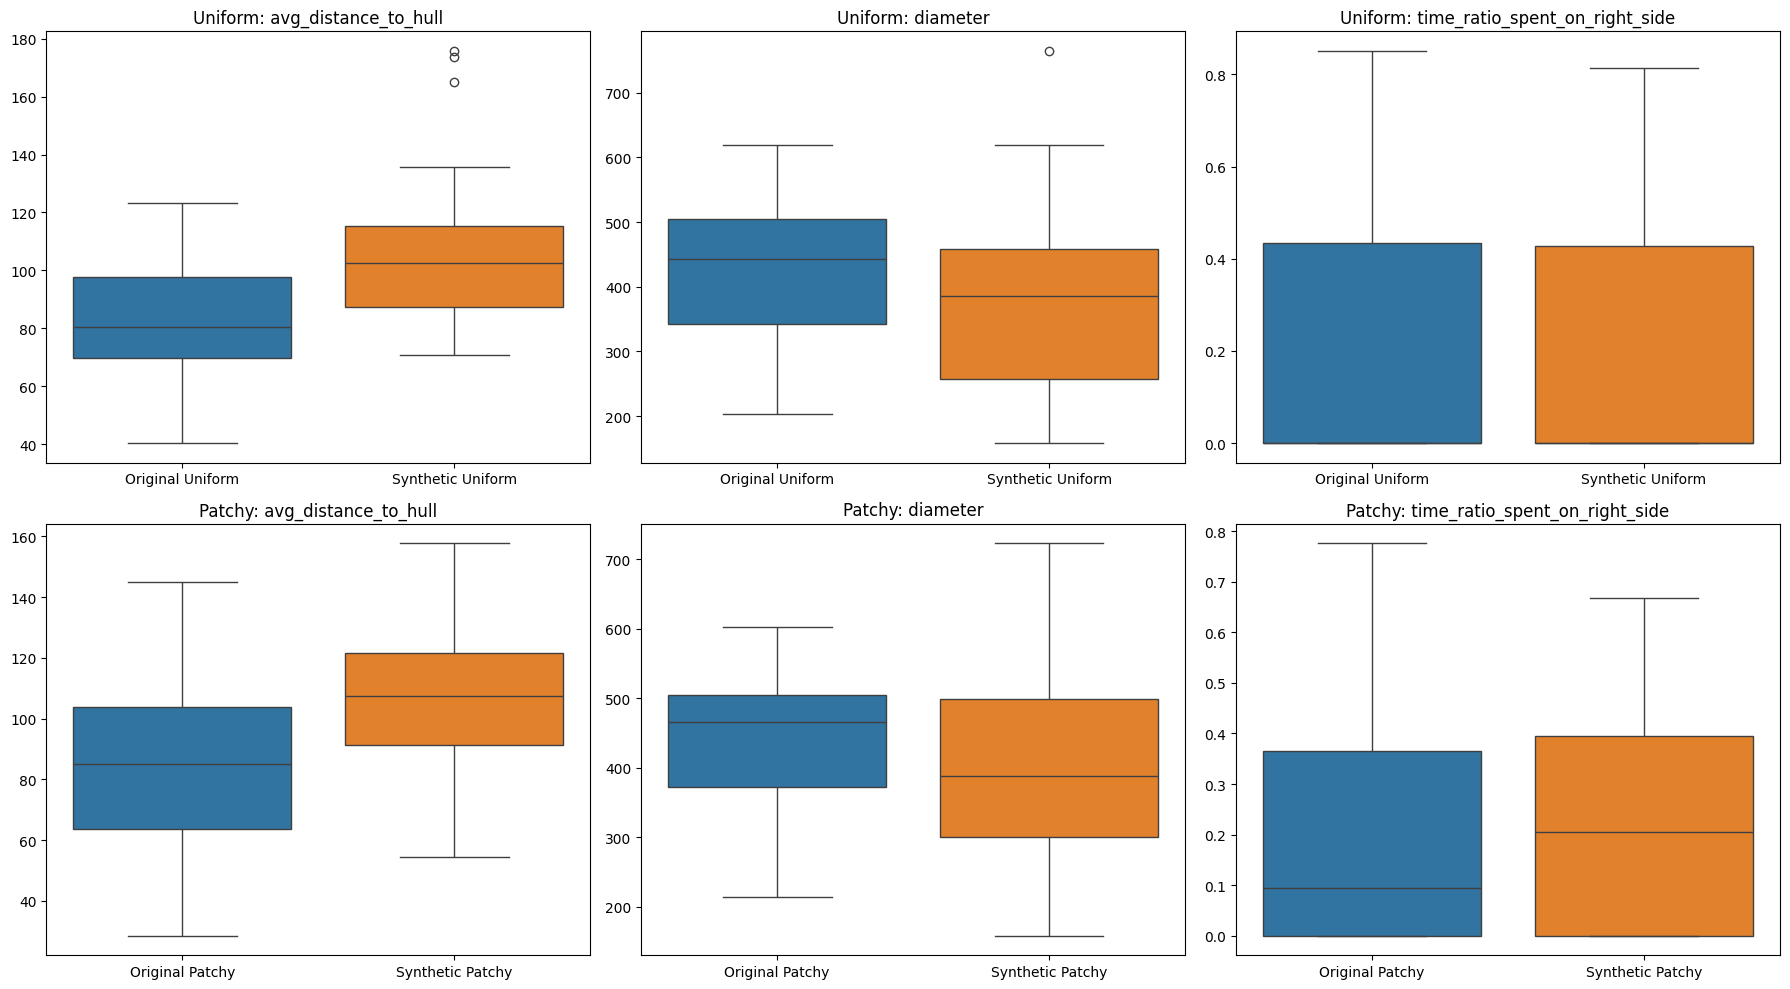

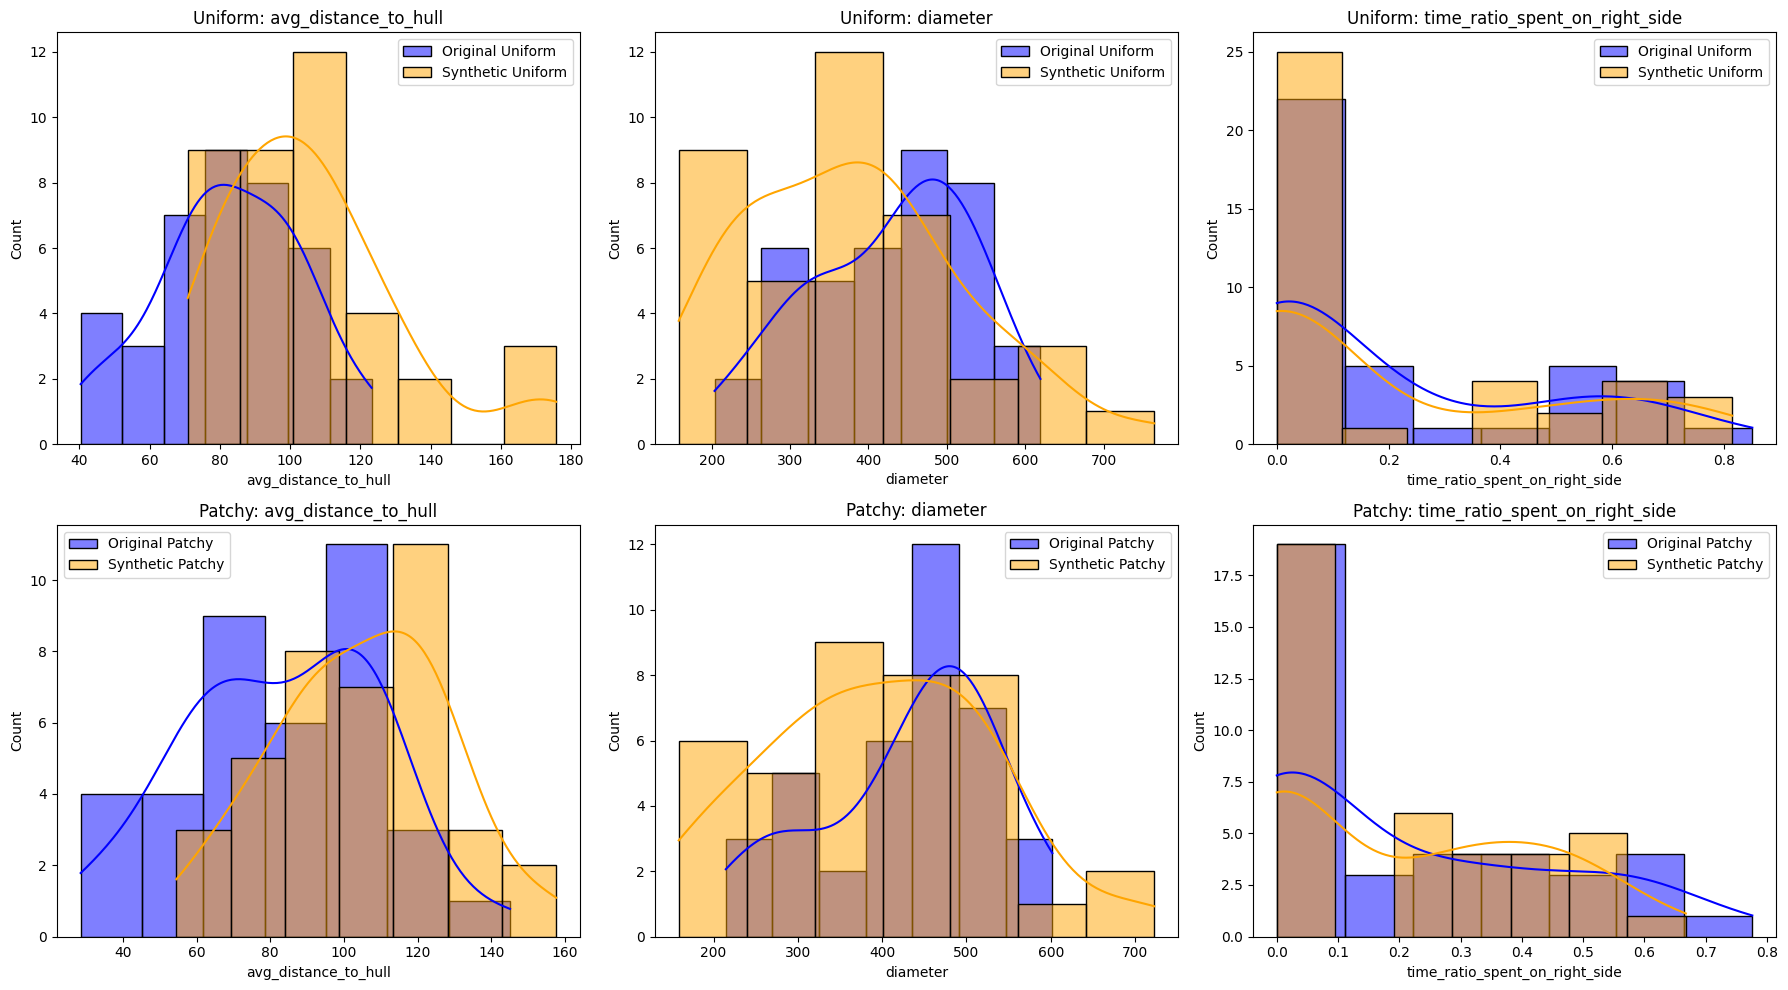


Métriques pour la variable patchy : avg_distance_to_hull
KS Statistic: 0.3576, p-value: 0.0082
Différence des moyennes: -21.6003

Métriques pour la variable patchy : diameter
KS Statistic: 0.2490, p-value: 0.1435
Différence des moyennes: 37.4762

Métriques pour la variable patchy : time_ratio_spent_on_right_side
KS Statistic: 0.1653, p-value: 0.5979
Différence des moyennes: -0.0003

Métriques pour la variable uniform : avg_distance_to_hull
KS Statistic: 0.4103, p-value: 0.0025
Différence des moyennes: -22.9205

Métriques pour la variable uniform : diameter
KS Statistic: 0.2821, p-value: 0.0897
Différence des moyennes: 48.4801

Métriques pour la variable uniform : time_ratio_spent_on_right_side
KS Statistic: 0.1026, p-value: 0.9885
Différence des moyennes: -0.0043


In [ ]:
import seaborn as sns
from scipy.stats import wasserstein_distance, kstest

variables = ['avg_distance_to_hull', 'diameter', 'time_ratio_spent_on_right_side']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Comparaison pour uniform
for i, variable in enumerate(variables):
    sns.boxplot(
        data=pd.DataFrame({
            'Original Uniform': original_features_uniform[variable],
            'Synthetic Uniform': synthetic_features_uniform[variable]
        }),
        ax=axes[0, i]  # Première ligne, i-ème colonne
    )
    axes[0, i].set_title(f'Uniform: {variable}')

# Comparaison pour patchy
for i, variable in enumerate(variables):
    sns.boxplot(
        data=pd.DataFrame({
            'Original Patchy': original_features_patchy[variable],
            'Synthetic Patchy': synthetic_features_patchy[variable]
        }),
        ax=axes[1, i]  # Deuxième ligne, i-ème colonne
    )
    axes[1, i].set_title(f'Patchy: {variable}')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Comparaison pour uniform 
for i, variable in enumerate(variables):
    sns.histplot(original_features_uniform[variable], color='blue', label='Original Uniform', kde=True, ax=axes[0, i])
    sns.histplot(synthetic_features_uniform[variable], color='orange', label='Synthetic Uniform', kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Uniform: {variable}')
    axes[0, i].legend()

# Comparaison pour patchy 
for i, variable in enumerate(variables):
    sns.histplot(original_features_patchy[variable], color='blue', label='Original Patchy', kde=True, ax=axes[1, i])
    sns.histplot(synthetic_features_patchy[variable], color='orange', label='Synthetic Patchy', kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'Patchy: {variable}')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

for variable in variables:
    print(f"\nMétriques pour la variable patchy : {variable}")
    
    # Test de Kolmogorov-Smirnov
    ks_stat, ks_p = kstest(original_features_patchy[variable], synthetic_features_patchy[variable])
    print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    
    # Différence des moyennes
    mean_diff = np.mean(original_features_patchy[variable]) - np.mean(synthetic_features_patchy[variable])
    print(f"Différence des moyennes: {mean_diff:.4f}")
    
for variable in variables:
    print(f"\nMétriques pour la variable uniform : {variable}")
    
    # Test de Kolmogorov-Smirnov
    ks_stat, ks_p = kstest(original_features_uniform[variable], synthetic_features_uniform[variable])
    print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    
    # Différence des moyennes
    mean_diff = np.mean(original_features_uniform[variable]) - np.mean(synthetic_features_uniform[variable])
    print(f"Différence des moyennes: {mean_diff:.4f}")



## Comparison of features restitution

We try here to reconstruct data throught the encoder decoder, and we compare how the model reconstructs features for each trajectory

In [ ]:
save_dir = GENERATED_TRAJECTORIES_PATH/"reconstructed_trajectories/"

original_files = [f for f in os.listdir(save_dir) if f.startswith("original_trajectory_")]
reconstructed_files = [f for f in os.listdir(save_dir) if f.startswith("reconstructed_trajectory_")]

original_data = []
reconstructed_data = []

for file in original_files:
    # Extraire l'ID du nom de fichier (ce sera un pseudo ID à priori, mais qui sera consistent)
    traj_id = int(file.split('_')[-1].split('.')[0])
    
    file_path = os.path.join(save_dir, file)
    traj_df = pd.read_csv(file_path)
    
    trajectory = traj_df[['x', 'y']].to_numpy()
    
    original_data.append({'id': traj_id, 'trajectory': trajectory})

# Charger les trajectoires reconstruites
for file in reconstructed_files:
    traj_id = int(file.split('_')[-1].split('.')[0])
    
    file_path = os.path.join(save_dir, file)
    traj_df = pd.read_csv(file_path)
    
    trajectory = traj_df[['x', 'y']].to_numpy()
    
    reconstructed_data.append({'id': traj_id, 'trajectory': trajectory})

df_original = pd.DataFrame(original_data)
df_reconstructed = pd.DataFrame(reconstructed_data)

# Trier les df par ID pour garantir la correspondance
df_original = df_original.sort_values(by='id').reset_index(drop=True)
df_reconstructed = df_reconstructed.sort_values(by='id').reset_index(drop=True)

print("DataFrame des trajectoires originales :")
print(df_original.head())

print("\nDataFrame des trajectoires reconstruites :")
print(df_reconstructed.head())


DataFrame des trajectoires originales :
   id                                         trajectory
0   1  [[-121.653, 195.312], [-121.65854, 195.31569],...
1   2  [[-121.653, 195.312], [-121.67086, 195.3237], ...
2   3  [[-121.653, 195.312], [-121.65854, 195.31569],...
3   4  [[-121.653, 195.312], [-121.00698, 195.69496],...
4   5  [[-121.653, 195.312], [-121.65854, 195.31569],...

DataFrame des trajectoires reconstruites :
   id                                         trajectory
0   1  [[-128.91759, 182.81598], [-115.22078, 167.719...
1   2  [[-165.36198, 267.53796], [-153.48256, 272.454...
2   3  [[-105.922005, 171.14583], [-115.00381, 177.56...
3   4  [[-66.16363, 122.19894], [-119.823265, 108.708...
4   5  [[-57.662285, 91.30286], [-85.785324, 88.88494...


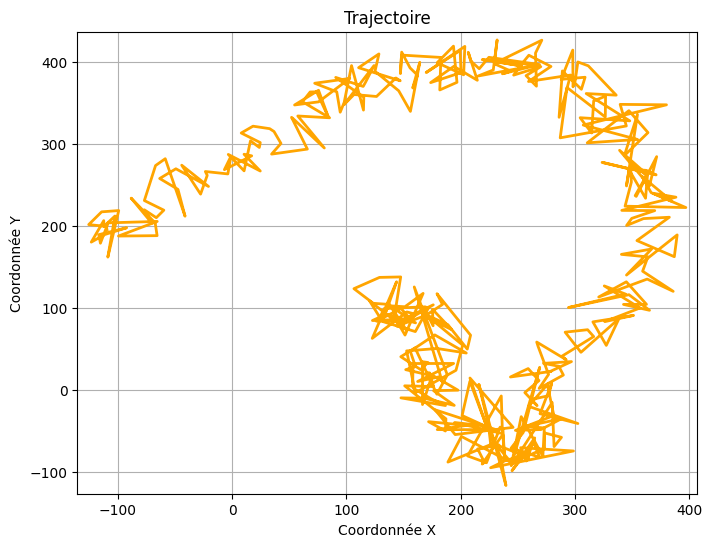

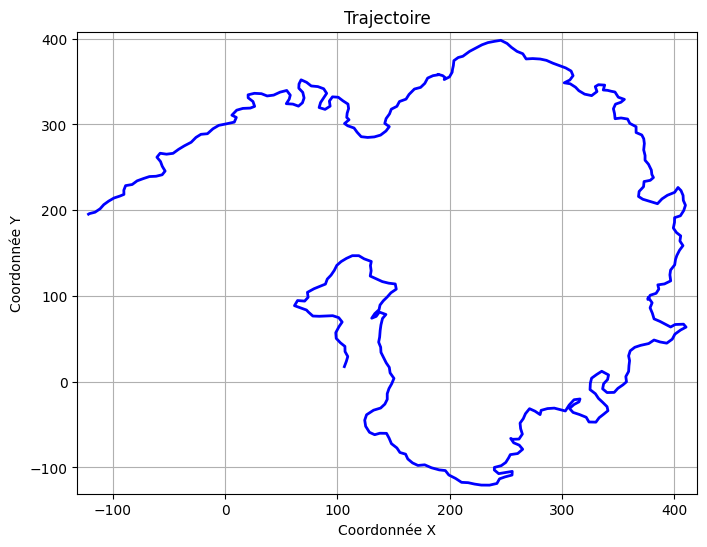

In [123]:
id = 13

plot_trajectory(df_reconstructed.loc[df_reconstructed['id'] == id]['trajectory'].values[0], line_color='orange')
plot_trajectory(df_original.loc[df_original['id'] == id]['trajectory'].values[0], line_color='blue')

In [124]:
df_original_hull = average_distance_to_hull(df_original, coords, 'euclidean')
df_reconstructed_hull = average_distance_to_hull(df_reconstructed, coords, 'euclidean')

df_original_diameter = compute_diameter(df_original)
df_reconstructed_diameter = compute_diameter(df_reconstructed)

df_original_ratio = compute_time_ratio(df_original)
df_reconstructed_ratio = compute_time_ratio(df_reconstructed)

df_original_features = pd.merge(df_original_diameter, df_original_ratio, on='id')
df_original_features = pd.merge(df_original_features, df_original_hull, on='id')

df_reconstructed_features = pd.merge(df_reconstructed_diameter, df_reconstructed_ratio, on='id')
df_reconstructed_features = pd.merge(df_reconstructed_features, df_reconstructed_hull, on='id')


Computing ratios: 100%|██████████| 39/39 [00:00<00:00, 49.95it/s]


Résultats des comparaisons par trajectoire :
    id  euclidean_distance  avg_distance_to_hull    diameter  \
0  0.0           60.280603             -0.367391   68.876255   
1  1.0           68.464375            -25.083794   42.029115   
2  2.0           63.148580             -9.034502   15.831576   
3  3.0           71.348533             -7.379941    3.539782   
4  4.0           84.399981            -40.458183  160.226843   

   time_ratio_spent_on_right_side  
0                          0.0000  
1                         -0.0375  
2                          0.0100  
3                          0.0500  
4                          0.0000  

Statistiques descriptives des métriques :
              id  euclidean_distance  avg_distance_to_hull    diameter  \
count  39.000000           39.000000             39.000000   39.000000   
mean   19.000000           85.194984            -25.782351   95.680213   
std    11.401754           29.389948             23.134621   94.257067   
min     0.00000

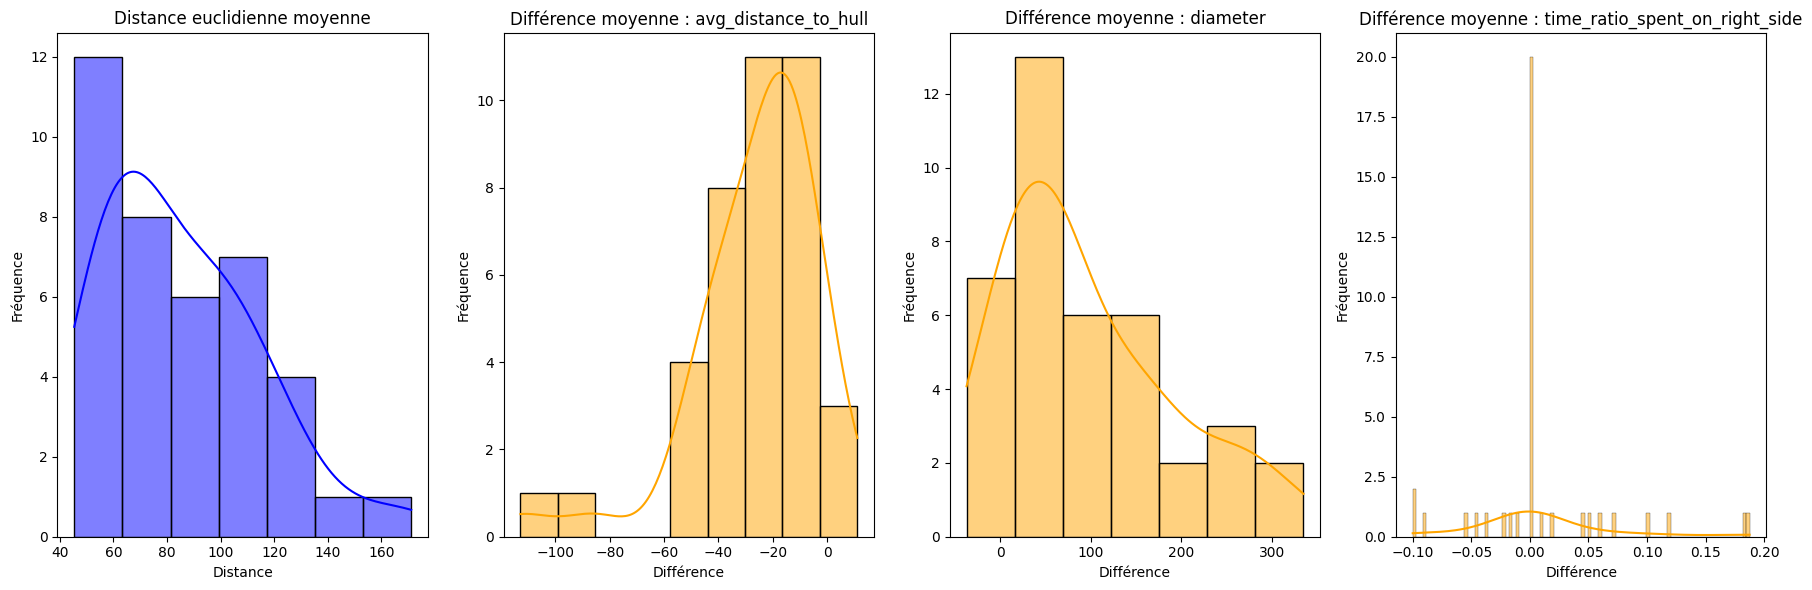

In [132]:
from scipy.spatial.distance import euclidean

variables = ['avg_distance_to_hull', 'diameter', 'time_ratio_spent_on_right_side']

# Initialiser un DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['id', 'euclidean_distance'] + variables)

# Calculer les métriques pour chaque paire de trajectoires
for idx, (original_traj, reconstructed_traj) in enumerate(zip(df_original['trajectory'], df_reconstructed['trajectory'])):
    # Vérifier que les trajectoires sont bien des tableaux 2D
    if original_traj.ndim != 2 or reconstructed_traj.ndim != 2:
        raise ValueError("Les trajectoires doivent être des tableaux 2D de forme (N, 2).")
    
    # Distance euclidienne moyenne entre les points correspondants
    euclidean_dist = np.mean([euclidean(original_traj[i], reconstructed_traj[i]) for i in range(len(original_traj))])
    
    # Différence moyenne pour chaque feature
    feature_diffs = {}
    for var in variables:
        feature_diffs[var] = np.mean(df_original_features[var].iloc[idx] - df_reconstructed_features[var].iloc[idx])
    
    # Ajouter les résultats au DataFrame
    results.loc[idx] = [idx, euclidean_dist] + list(feature_diffs.values())

# Afficher les résultats
print("Résultats des comparaisons par trajectoire :")
print(results.head())

# Statistiques descriptives
print("\nStatistiques descriptives des métriques :")
print(results.describe())

# Visualiser les écarts
plt.figure(figsize=(18, 6))

# Distance euclidienne moyenne
plt.subplot(1, len(variables) + 1, 1)
sns.histplot(results['euclidean_distance'], kde=True, color='blue')
plt.title('Distance euclidienne moyenne')
plt.xlabel('Distance')
plt.ylabel('Fréquence')

# Différence moyenne des features (un graphique par feature)
for i, var in enumerate(variables):
    plt.subplot(1, len(variables) + 1, i + 2)
    sns.histplot(results[var], kde=True, color='orange')
    plt.title(f'Différence moyenne : {var}')
    plt.xlabel('Différence')
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()
